# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
## Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
## Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

## Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# Обзор данных

У нас 5 таблиц для анализа данных. Прочитаем каждую таблицу и изучим данные.

## Таблица с информацей о звонках

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

df_calls = pd.read_csv('/datasets/calls.csv')
display(df_calls.head(10))
df_calls.info()
df_calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Переименуем столбец id в id_call. Переведем столбец call_date в формат даты, a user_id в целочисленный формат.

In [ ]:
df_calls = df_calls.rename(
    columns={'id': 'id_call'})

df_calls['user_id'] = df_calls['user_id'].astype(int)
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id_call    202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Так как каждый звонок оператор округляет вверх до минуты, то округлим сразу все звонки до целых значений вверх и установим целочисленный формат данных.

In [ ]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls.head()

,id_call,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Проверим есть ли дуликаты

In [ ]:
df_calls.duplicated().sum()

0

## Таблица с данными об интернет-сессиях

In [ ]:
df_internet = pd.read_csv('/datasets/internet.csv')
display(df_internet.head(10))
df_internet.info()
df_internet.describe()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


По столбцу id сложно понять о чем идет речь. Перееменуем его в id_session. 
Столбец Unnamed: 0 судя по всему это индекс строк. Не знаю понадобится ли он нам, поэтому пока сохраним его и переименуем в index.
Столбец session_date переведем в формат даты.

In [ ]:
df_internet = df_internet.rename(
columns={
    'id': 'id_session',
    'Unnamed: 0': 'index',
})
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet.head()

,index,id_session,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Проверяем есть ли в данных дубликаты.

In [ ]:
df_internet.duplicated().sum()

0

## Таблица с информацей о сообщениях

In [ ]:
df_messages = pd.read_csv('/datasets/messages.csv')

display(df_messages.head(10))
df_messages.info()
df_messages.describe()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


По столбцу id сложно понять о чем идет речь. Перееменуем его в id_messege. Столбец message_date переведем в формат даты.

In [ ]:
df_messages = df_messages.rename(
columns={'id': 'id_message'})

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.head()

,id_message,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Проверяем на дубли.

In [ ]:
df_messages.duplicated().sum()

0

## Таблица с тарифами

In [ ]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Таблица с информацией о пользователях

In [ ]:
df_users = pd.read_csv('/datasets/users.csv')
display(df_users.head(10))
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Столбец reg_date и chutn_date переведем в формат даты.

In [ ]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [ ]:
df_users.duplicated().sum()

0

## Выводы:
В результате предобработки мы изучили 5 таблиц с данными по использованию тарифов Мегалайн (звонки, SMS, интернет-сессии, описание тарифов, данные пользователей). Изучили основные статистические характеристики данных, проверили данные на дубликаты, исправили название некоторых столбцов, перевели данные в удобный для анализа формат, округлили продолжительность звонков до минут.

# Расчеты

## Количество сделанных звонков и израсходованных минут разговора по месяцам

In [ ]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
calls_agg = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_agg.head()

count      sum
              duration duration
user_id month                  
1000    5           22      159
        6           43      172
        7           47      340
        8           52      408
        9           58      466

## Количество отправленных сообщений по месяцам

In [ ]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
messages_agg = df_messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_agg.columns = ['message_count']
messages_agg.head()

message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57

## Объем израсходованного интернет-трафика по месяцам

In [ ]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
internet_agg = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum'])
internet_agg.columns = ['mb_used']
internet_agg.head()

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

## Помесячная выручка с каждого пользователя

Для того, чтобы посчитать итоговую прибыль компании с каждого пользователя нам нужно собрать все данные для вычислений в единую таблицу.

In [ ]:
all_pivot_table = internet_agg.join([calls_agg, messages_agg],  how='outer').reset_index(level='month')
all_pivot_table.columns = ['month', 'mb_used', 'count_duration', 'sum_duration', 'count_message']
all_pivot_table.head()

,month,mb_used,count_duration,sum_duration,count_message
user_id,,,,,
1000,5,2253.49,22.0,159.0,22.0
1000,6,23233.77,43.0,172.0,60.0
1000,7,14003.64,47.0,340.0,75.0
1000,8,14055.93,52.0,408.0,81.0
1000,9,14568.91,58.0,466.0,57.0


In [ ]:
all_pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1000 to 1499
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           3214 non-null   int64  
 1   mb_used         3203 non-null   float64
 2   count_duration  3174 non-null   float64
 3   sum_duration    3174 non-null   float64
 4   count_message   2717 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


Объединяем df_users и единую сводную таблицу

In [ ]:
total_data = df_users.join(all_pivot_table, on='user_id', how='inner')
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,mb_used,count_duration,sum_duration,count_message
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,2253.49,22.0,159.0,22.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,23233.77,43.0,172.0,60.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,14003.64,47.0,340.0,75.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,14055.93,52.0,408.0,81.0
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,14568.91,58.0,466.0,57.0


Удалим столбцы, которые нам не пригодятся чтобы легче было ориентироваться в таблице.

In [ ]:
total_data = total_data.drop(['churn_date', 'first_name', 'last_name', 'reg_date'], axis='columns')
total_data.head()

,user_id,age,city,tariff,month,mb_used,count_duration,sum_duration,count_message
0,1000,52,Краснодар,ultra,5,2253.49,22.0,159.0,22.0
0,1000,52,Краснодар,ultra,6,23233.77,43.0,172.0,60.0
0,1000,52,Краснодар,ultra,7,14003.64,47.0,340.0,75.0
0,1000,52,Краснодар,ultra,8,14055.93,52.0,408.0,81.0
0,1000,52,Краснодар,ultra,9,14568.91,58.0,466.0,57.0


Добавим к нашей таблице информацию о тарифах из таблицы df_tariffs. 

Объединим таблицы по колонке с названиями тарифов. Для этого сначала в df_tariffs поменяем название нужного столбца на tariff.

In [ ]:
df_tariffs = df_tariffs.rename(
columns={'tariff_name': 'tariff'})
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объеденим данные.

In [ ]:
total_data = total_data.merge(df_tariffs, on='tariff')
total_data.head()

,user_id,age,city,tariff,month,mb_used,count_duration,sum_duration,count_message,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5,2253.49,22.0,159.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6,23233.77,43.0,172.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7,14003.64,47.0,340.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8,14055.93,52.0,408.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9,14568.91,58.0,466.0,57.0,1000,30720,3000,1950,150,1,1


In [ ]:
df_calls['duration'].sum()

1450301

In [ ]:
total_data['sum_duration'].sum() 

1450301.0

Проверим данные на пропуски, появившиеся при объединении.

In [ ]:
total_data.isna().sum()

user_id                    0
age                        0
city                       0
tariff                     0
month                      0
mb_used                   11
count_duration            40
sum_duration              40
count_message            497
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

По какой-то причине в нашей итоговой таблице образовались пропуски, возможно клиент просто в эти периоды не отправлял сообщения, не звонил или не выходил в интернет. Заменим пропуски нулями.

In [ ]:
total_data = total_data.fillna(0)
total_data.isna().sum()

user_id                  0
age                      0
city                     0
tariff                   0
month                    0
mb_used                  0
count_duration           0
sum_duration             0
count_message            0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Создадим функцию для расчет помесячной выручки с каждого пользователя.

In [ ]:
def total_bill_monthly(row):
    
    bill_call = 0
    bill_message = 0
    bill_internet = 0
    calls = row['sum_duration']
    message = row['count_message']
    internet = row['mb_used']
    tariff = row['tariff']
    minutes_limit = row['minutes_included']
    message_limit = row['messages_included']
    internet_limit = row['mb_per_month_included']
    monthly_fee = row['rub_monthly_fee']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']
    
    if calls > minutes_limit:
        bill_call += (calls- minutes_limit) * rub_per_minute
    else:
        bill_minutes = 0
    if message > message_limit:
        bill_message += (message - message_limit) * rub_per_message
    else:
        bill_message = 0
    if internet > internet_limit:
        bill_internet += (np.ceil((internet - internet_limit) / 1024)) * rub_per_gb
    else:
        bill_internet = 0
        
    return bill_call + bill_message + bill_internet + monthly_fee

total_data['total_bill'] = total_data.apply(total_bill_monthly, axis=1)
total_data.head()

,user_id,age,city,tariff,month,mb_used,count_duration,sum_duration,count_message,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_bill
0,1000,52,Краснодар,ultra,5,2253.49,22.0,159.0,22.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,Краснодар,ultra,6,23233.77,43.0,172.0,60.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,Краснодар,ultra,7,14003.64,47.0,340.0,75.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,Краснодар,ultra,8,14055.93,52.0,408.0,81.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,Краснодар,ultra,9,14568.91,58.0,466.0,57.0,1000,30720,3000,1950,150,1,1,1950.0


# Анализ данных

Посмотрим распределение средних количеств сообщений, интернет-трафика и звонков по месяцам и по тарифам. 

In [ ]:
clients_pivot = (total_data
                 .pivot_table(index=['tariff', 'month'], 
                  values=['sum_duration', 'count_message', 'mb_used', 'total_bill'])
)

clients_pivot = clients_pivot.reset_index(level='tariff')
display(clients_pivot)

,tariff,count_message,mb_used,sum_duration,total_bill
month,,,,,
1,smart,18.235294,8513.717647,203.852941,721.323529
2,smart,24.086207,11597.054310,298.689655,827.603448
3,smart,31.857143,15104.159091,390.051948,1164.623377
4,smart,30.741071,13462.180625,367.133929,963.089286
5,smart,33.773050,15805.184326,387.361702,1197.510638
6,smart,33.402439,15794.647988,395.640244,1204.018293
7,smart,33.751244,15743.150348,408.353234,1223.950249
8,smart,33.638298,16610.720085,421.468085,1320.595745
9,smart,33.638462,16303.578808,428.611538,1249.946154


Если проанализировать значения по месяцам, то мы видим, что средние значения растут месяц к месяцу. С чем это может быть связано?

Мое предположение, что количество пользователей каждый месяц увеличивается. Проверим это предположение.

In [ ]:
clients_count_per_month = total_data.pivot_table(index=['tariff', 'month'], values=['user_id'], aggfunc='count')
clients_count_per_month

user_id
tariff month         
smart  1           34
       2           58
       3           77
       4          112
       5          141
       6          164
       7          201
       8          235
       9          260
       10         294
       11         316
       12         337
ultra  1            9
       2           24
       3           37
       4           55
       5           67
       6           84
       7           91
       8          107
       9          115
       10         123
       11         134
       12         139

Действительно, количество пользователей растет каждый месяц. Хотя, это и логично. Было бы странно, если бы количество клиентов не росло. В идеале можно посчитать скорость прироста клиентов каждый месяц в каждом тарифе. Или если бы у нас были данных по рекламным кампания, то мы могли бы проанализировать во сколько обходится клиент на каждом тарифе.

Посчитаем среднее, дисперсию и стандартное отклонение по количеству звонков, SMS, интернет-трафику и выручке по каждому тарифу за весь анализируемый период.

In [ ]:
#среднее, дисперсия и стандартное отклонение по звонкам в тарифах "Смарт" и "Ультра"
display(total_data
        .pivot_table(index=['tariff'], 
         values='sum_duration',
         aggfunc=['mean', 'var', 'std'])
)

#среднее, дисперсия и стандартное отклонение по SMS в тарифах "Смарт" и "Ультра"
display(total_data
        .pivot_table(index=['tariff'], 
         values='count_message',
         aggfunc=['mean', 'var', 'std'])
)

#среднее, дисперсия и стандартное отклонение по интернет трафику в тарифах "Смарт" и "Ультра"
display(total_data
        .pivot_table(index=['tariff'], 
         values='mb_used',
         aggfunc=['mean', 'var', 'std'])
)

#среднее, дисперсия и стандартное отклонение по прибыли за месяц в тарифах "Смарт" и "Ультра"
display(total_data
        .pivot_table(index=['tariff'], 
         values='total_bill',
         aggfunc=['mean', 'var', 'std'])
)

,mean,var,std
,sum_duration,sum_duration,sum_duration
tariff,,,
smart,417.934948,36219.315784,190.313730
ultra,526.623350,100873.633397,317.606098


,mean,var,std
,count_message,count_message,count_message
tariff,,,
smart,33.384029,796.812958,28.227876
ultra,49.363452,2285.266143,47.804457


,mean,var,std
,mb_used,mb_used,mb_used
tariff,,,
smart,16208.386990,3.446250e+07,5870.476681
ultra,19468.805208,1.017510e+08,10087.170752


,mean,var,std
,total_bill,total_bill,total_bill
tariff,,,
smart,1289.973531,669785.708006,818.404367
ultra,2070.152284,141516.745079,376.187114


По данным мы видим, что пользователи тарифа "Ультра" в среднем больше приносят прибыли, а также большем объеме используют все услуги компании. Т.е. в перерасчете на 1 пользователя тариф "Ультра" выгоднее, но стоит проанализировать общий объем пользователей в каждом тарифе и их суммарную прибыль. Этим мы займемся позже.

Из данных мы видим, что стандартное отклонение и дисперсия в тарифе "Ультра" больше, чем в "Смарт" во всех случаях, кроме выручки от каждого пользователя. Это говорит нам о том, что значения в тарифе "Ультра" распределены в более широком диапазоне. А вот в прибыли от пользователей ситуация противоположная, в тарифе "Ультра" разброс прибыли не такой значительный, как в "Смарт"

Посмотрим распределение данных об использовании услуг тарифных пакетов и выручки с каждого пользователя на графиках. 

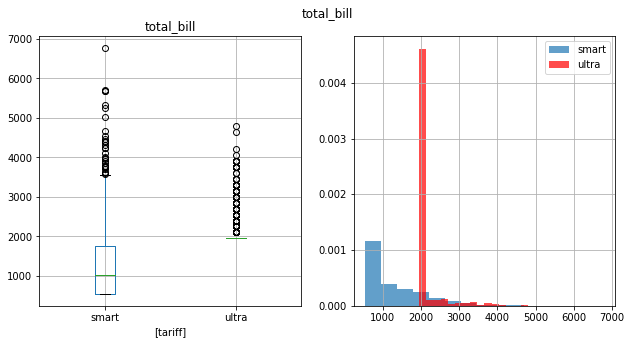

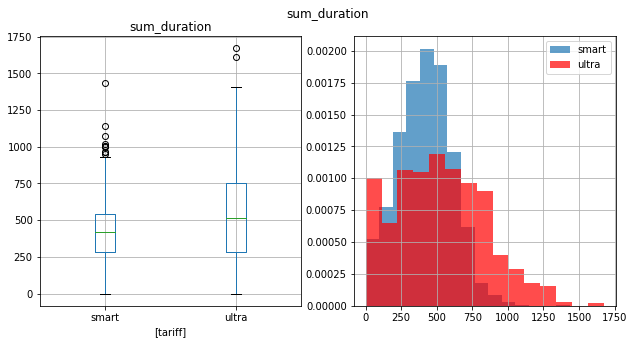

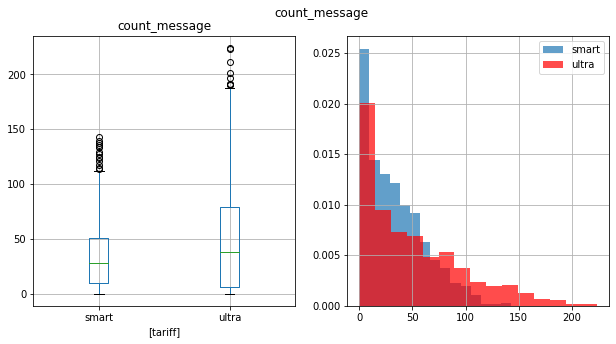

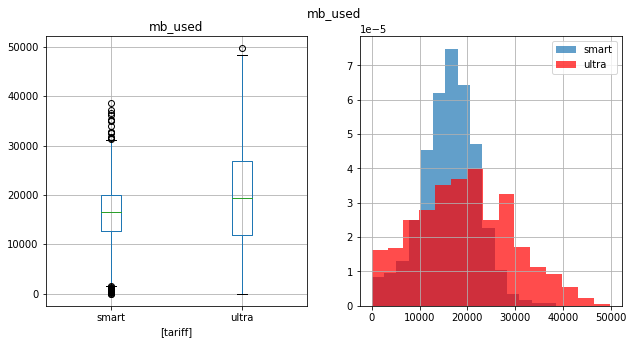

In [ ]:
graph=['total_bill', 'sum_duration', 'count_message',  'mb_used']

for y in graph:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    total_data[['tariff', y]].boxplot(by='tariff', ax=ax1)
    total_data.query('tariff == "smart"')[y].hist(bins=15, ax=ax2, alpha=.7, label='smart', density=1)
    total_data.query('tariff == "ultra"')[y].hist(bins=15, ax=ax2, color='Red', alpha=.7, label='ultra', density=1)
    ax2.legend(prop={'size': 10})
    fig.suptitle(y)

- Как и говорилось выше, разброс значений в тарифе "Ультра" намного шире, чем в "Смарт" (исключение составляет выручка от пользователя). Распределение данных в тарифе "Смарт" намного уже, возможно это связано просто с ограничениями самого тарифного пакета. <br/>

- Графики по распределению объема отправленных клиентами SMS больше всего отличается от нормального распределения. Большинство клиентов в обоих тарифах отправляют небольшое количество сообщений. В мире мессенжеров это вполне предсказуемо.

- График по выручке прекрасно иллюстрирует, что большинство клиентов тарифе "Ультра" платят только за стоимость пакета и практически не доплачивают за доп.услуги. В тарифе "Смарт" разброс выручки намного больше, многие клиенты доплачивают за доп.услуги.

На тарифе "Ультра" почти все пользователи платят только абонентскую плату. Единицы из них доходит до порога по минутам или СМС. Есть категория пользователей, которым нужно больше 30Гб в месяц.
На тарифе "Смарт" только половине пользователей хватает пакета минут в месяц. Четверти не хватает пакета SMS. И больше половины пользователей докупает интернет.

# Проверка гипотез

## Проверка первой гипотезы. 

В качестве нулевой гипотезы возьмем: <b>"Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны"</b>.<br/>
В качестве альтернативной гипотезы возьмем: <b>"Cредняя выручка пользователей тарифов «Ультра» и «Смарт» не равны"</b>.

Для этого воспользуемся методом проверки гипотезы о равенстве двух генеральных совокупностей по взятым из них выборкам. Если пороговое значение окажется меньше 0.05, будем считать что гипотеза подтвердилась.

Проверяем нашу гипотезу.

In [ ]:
alpha = .05
results = st.ttest_ind(
    total_data.query('tariff == "smart"')['total_bill'], 
    total_data.query('tariff == "ultra"')['total_bill'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


p-значение очень маленькое, мы отвергаем нашу гипотезу. Средняя выручка с тарифов отличается.

## Проверка второй гипотезы.

В качестве нулевой гипотезы возьмем: <b>"Cредняя выручка пользователей из Москвы равна средней выручке из других регионов</b>.<br/>
В качестве альтернативной гипотезы возьмем:<b>"Cредняя выручка пользователей из Москвы не равна средней выручке из других регионов</b>.

Проверим гипотезу по каждому тарифу отдельно.

In [ ]:
total_data['is_moscow'] = np.where(total_data['city'] == 'Москва', True, False)

Проверяем тариф "Смарт".

In [ ]:
alpha = .05
results = st.ttest_ind(
    total_data.query('tariff == "smart" and is_moscow == True')['total_bill'], 
    total_data.query('tariff == "smart" and is_moscow == False')['total_bill'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.18150864159228705
Не получилось отвергнуть нулевую гипотезу


Проверим тариф "Ультра"

In [ ]:
alpha = .05
results = st.ttest_ind(
    total_data.query('tariff == "ultra" and is_moscow == True')['total_bill'], 
    total_data.query('tariff == "ultra" and is_moscow == False')['total_bill'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8614477943640767
Не получилось отвергнуть нулевую гипотезу


По обоим тарифам не получилось отвергнуть нулевую гипотезу. Значит выручка от пользователей из Москвы и регионов на одних и тех же тарифах практически не отличается.
Проверим также нашу гипотезу на всей выборке, без деления на тарифы.

In [ ]:
alpha = .05
results = st.ttest_ind(
    total_data.query('is_moscow == True')['total_bill'], 
    total_data.query('is_moscow == False')['total_bill'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Даже если мы не делим Москву и регионы по тарифу, все равно прибыль от пользователей отличается незначительно.

# Расчеты для выводов:

Перед тем как делать окончательные выводы и оформлять рекомендации, нам нужно вернуться к вопросу вклада общего количества пользователей в каждый тариф, а следовательно и в выручку от всего тарифа. <br/>
Будем считать, что выборка, которую мы анализируем является репрезентативной и соотношение пользователей двух тарифов такая же как и во всей базе. 

In [ ]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [ ]:
total_data.query('tariff == "smart"')['total_bill'].describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: total_bill, dtype: float64

In [ ]:
total_data.query('tariff == "ultra"')['total_bill'].describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: total_bill, dtype: float64

Мы видим, что общее количество пользователей в тарифе "Смарт" в 2 раза больше, чем в "Ультра". И не смотря на то, что средняя выручка от каждого пользователя в "Ультра" больше, суммарная выручка от всего тарифа больше в "Смарт".

,tariff,month,total_bill
0,smart,1,24525.0
1,smart,2,48001.0
2,smart,3,89676.0
3,smart,4,107866.0
4,smart,5,168849.0
5,smart,6,197459.0
6,smart,7,246014.0
7,smart,8,310340.0
8,smart,9,324986.0
9,smart,10,401267.0


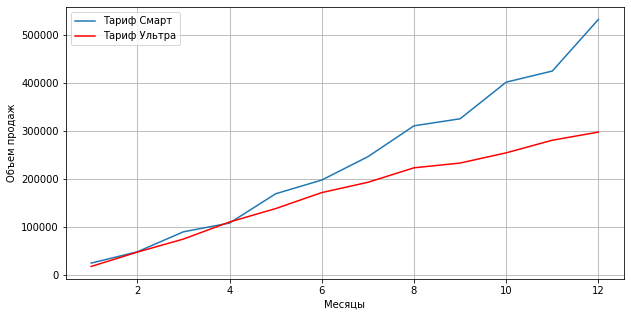

In [ ]:
clients_bill = total_data.pivot_table(index=['tariff', 'month'], values='total_bill', aggfunc='sum').reset_index()
display(clients_bill)

ax = clients_bill.query('tariff == "smart"').plot(x='month', y='total_bill', grid=True, figsize=(10, 5), legend='Смарт')
clients_bill.query('tariff == "ultra"').plot(x='month', y='total_bill', grid=True, color='Red', figsize=(10, 5), ax=ax)

plt.xlabel('Месяцы')
plt.ylabel('Объем продаж')
ax.legend(['Тариф Смарт', 'Тариф Ультра'])
plt.show()

Если исходить из того, что у нас репрезентативная выборка, то пользователей тарифа Смарт в 2 раза больше, чем пользователей Ультра. 

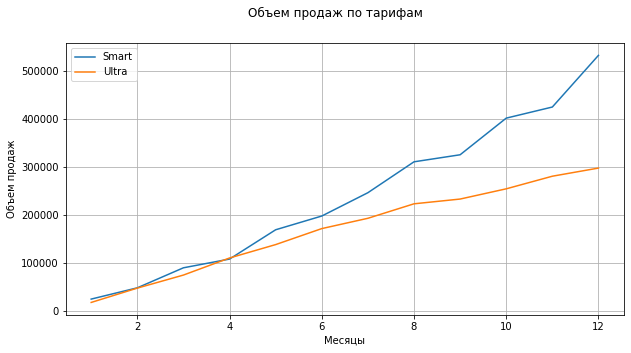

In [ ]:
# код ревьюера

fig, ax = plt.subplots(figsize=(10, 5))

x = clients_bill.query('tariff == "smart"')['month']
y1 = clients_bill.query('tariff == "smart"')['total_bill']
y2 = clients_bill.query('tariff == "ultra"')['total_bill']

ax.plot(x, y1, label = 'Smart')
ax.plot(x, y2 , label = 'Ultra')

fig.suptitle('Объем продаж по тарифам')
plt.xlabel('Месяцы')
plt.ylabel('Объем продаж')

ax.grid()
ax.legend()
plt.show()

## Выводы:
 - В пересчёте на одного пользователя тариф "Ультра" значительно выгоднее для Мегалайна. Но суммарно по пользователям тариф "Смарт" приносит практически в 2 раза больше выручки в месяц.

 - По представленной выборке мы можем сделать вывод, что зависимости средней выручки от региона нет.

Если рост пользователей будет оставаться таким же, то рекламный упор стоит сделать на тариф "Смарт".